In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polpo.preprocessing.dict as ppdict
import polpo.preprocessing.pd as ppd
from polpo.model_eval import (
    MultiEvaluator,
    OlsPValues,
    R2Score,
    ReconstructionError,
    ShapeCollector,
    VertexReconstructionError,
    collect_eval_results,
)
from polpo.preprocessing import (
    IndexMap,
    Map,
    NestingSwapper,
    PartiallyInitializedStep,
)
from polpo.preprocessing.load.pregnancy import (
    NeuroMaternalMeshLoader,
    NeuroMaternalTabularDataLoader,
)
from polpo.preprocessing.mesh.conversion import PvFromData, ToVertices
from polpo.preprocessing.mesh.io import FreeSurferReader
from polpo.preprocessing.mesh.registration import PvAlign
from polpo.sklearn.adapter import AdapterPipeline, EvaluatedModel
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [2]:
DEBUG = False

EDS.

In [3]:
pipe = NeuroMaternalTabularDataLoader(
    keep_mothers=True,
    keep_control=False,
)

tab_data = pipe()

In [4]:
eds_pipe = (
    ppd.DfFilter(lambda df: df["ses"] == 1)
    + ppd.IndexSetter("participant_id", drop=True)
    + ppd.ColumnsSelector("EDS.Total")
    + ppd.SeriesToDict()
)

eds_dict = eds_pipe(tab_data)

Meshes and vector fields.

In [5]:
as_dict = False
file_finder = NeuroMaternalMeshLoader(as_dict=as_dict)

Map_ = ppdict.DictMap if as_dict else Map


mesh_reader = ppdict.DictMap(Map_(FreeSurferReader() + PvFromData()))

prep_pipe = PartiallyInitializedStep(
    Step=lambda **kwargs: ppdict.DictMap(Map_(PvAlign(**kwargs))),
    # NB: aligns against first subject, t_0
    _target=lambda meshes: meshes[list(meshes.keys())[0]][0],
    max_iterations=500,
)


if DEBUG:
    # because alignment is a bit slow
    pipe = file_finder + mesh_reader
else:
    pipe = file_finder + mesh_reader + prep_pipe


meshes_dict = pipe()

len(meshes_dict)

151

In [6]:
meshes2flat_vfields = ppdict.DictMap(
    step=Map(ToVertices()) + (lambda verts: (verts[1] - verts[0]).flatten())
)

flat_vfields_dict = meshes2flat_vfields(meshes_dict)

len(flat_vfields_dict)

151

In [7]:
# TODO: this can be simplified, i.e. PLSRegression computes linreg coeffs
model = EvaluatedModel(
    AdapterPipeline(
        [
            (
                "prep",
                EvaluatedModel(
                    PLSRegression(n_components=1),
                    MultiEvaluator(
                        [
                            ReconstructionError(),
                            VertexReconstructionError(prefix="vertex"),
                            ShapeCollector(),
                        ]
                    ),
                ),
            ),
            (
                "regr",
                EvaluatedModel(
                    LinearRegression(),
                    MultiEvaluator([OlsPValues(), R2Score(), ShapeCollector()]),
                ),
            ),
        ]
    ),
    MultiEvaluator([R2Score(), ShapeCollector()]),
)

model

,model,AdapterPipeli...gression()))])
,evaluator,<polpo.model_...x737af4ead850>
,model,PLSRegression(n_components=1)
,evaluator,<polpo.model_...x737af4ead010>
,n_components,1
,scale,True
,max_iter,500
,tol,1e-06
,copy,True
,model,LinearRegression()
,evaluator,<polpo.model_...x737af4eaecf0>


In [8]:
dataset_pipe = (
    ppdict.DictMerger()
    + NestingSwapper()
    + IndexMap(index=0, step=lambda x: np.stack(x))
    + IndexMap(index=1, step=lambda x: np.stack(x)[:, None])
)


flat_vfields, eds = dataset_pipe((flat_vfields_dict, eds_dict))

flat_vfields.shape, eds.shape

((117, 7506), (117, 1))

In [9]:
X, y = flat_vfields, eds

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


model.fit(X_train, y_train)

,model,AdapterPipeli...gression()))])
,evaluator,<polpo.model_...x737af4ead850>
,model,PLSRegression(n_components=1)
,evaluator,<polpo.model_...x737af4ead010>
,n_components,1
,scale,True
,max_iter,500
,tol,1e-06
,copy,True
,model,LinearRegression()
,evaluator,<polpo.model_...x737af4eaecf0>


In [10]:
model.predict_eval(X_test, y_test);

In [11]:
eval_res_train = collect_eval_results(model, unnest=True, outer_key="full")

print(list(eval_res_train.keys()))

['full', 'full/prep', 'full/regr']


In [12]:
eval_res_test = collect_eval_results(model, unnest=True, outer_key="full", train=False)

print(list(eval_res_test.keys()))

['full', 'full/prep', 'full/regr']


Eval results of full pipeline.

In [13]:
eval_res_train["full"]

{'r2': array([0.11808424]),
 'X-shape': (93, 7506),
 'y-shape': (93, 1),
 'y_pred-shape': (93, 1)}

In [14]:
eval_res_test["full"]

{'r2': array([-0.25945156]),
 'X-shape': (24, 7506),
 'y-shape': (24, 1),
 'y_pred-shape': (24, 1)}

Eval results of inner regression (PLS component -> EDS).

In [15]:
eval_res_train["full/regr"]

{'mse': array([20.8425378]),
 'res_var': array([21.30061555]),
 'std_err': array([[0.02007068]]),
 't': array([[3.49062432]]),
 'pvals': array([[0.00074522]]),
 'adj-pvals': array([[0.00074522]]),
 'r2': array([0.11808424]),
 'X-shape': (93, 1),
 'y-shape': (93, 1),
 'y_pred-shape': (93, 1)}

In [16]:
eval_res_test["full/regr"]

{'mse': array([31.68745141]),
 'res_var': array([34.56812881]),
 'std_err': array([[0.05894786]]),
 't': array([[1.18849438]]),
 'pvals': array([[0.2473104]]),
 'adj-pvals': array([[0.2473104]]),
 'r2': array([-0.25945156]),
 'X-shape': (24, 1),
 'y-shape': (24, 1),
 'y_pred-shape': (24, 1)}

Eval results of PLS reconstruction.

In [17]:
eval_res_train["full/prep"]

{'featurewise_rec_error': array([10.37348073, 15.8049983 ,  5.64221018, ..., 31.66168813,
        23.40463307, 11.95181456], shape=(7506,)),
 'rec_error_sum': np.float64(79476.07476776226),
 'rec_error_mse': np.float64(0.11385311072684828),
 'vertex-vertexwise_rec_error': array([31.82068921, 31.59199178, 34.31348596, ..., 66.7005602 ,
        70.94504816, 67.01813576], shape=(2502,)),
 'vertex-rec_error_sum': np.float64(79476.07476776224),
 'vertex-rec_error_mse': np.float64(0.3415593321805448),
 'X-shape': (93, 7506),
 'y-shape': (93, 1),
 'y_pred-shape': (93, 1)}

In [18]:
eval_res_test["full/prep"]

{'featurewise_rec_error': array([ 3.9023589 ,  3.72731863,  1.41154   , ..., 15.12508342,
         8.59064383,  2.2998313 ], shape=(7506,)),
 'rec_error_sum': np.float64(26128.165844031042),
 'rec_error_mse': np.float64(0.14504044455563905),
 'vertex-vertexwise_rec_error': array([ 9.04121753,  9.4191727 ,  8.25619461, ..., 25.19143405,
        27.46695263, 26.01555855], shape=(2502,)),
 'vertex-rec_error_sum': np.float64(26128.165844031042),
 'vertex-rec_error_mse': np.float64(0.4351213336669172),
 'X-shape': (24, 7506),
 'y-shape': (24, 1),
 'y_pred-shape': (24, 1)}

Visualization.

Text(0.5, 1.0, 'Linear Regression: Deformation Component vs. EPDS')

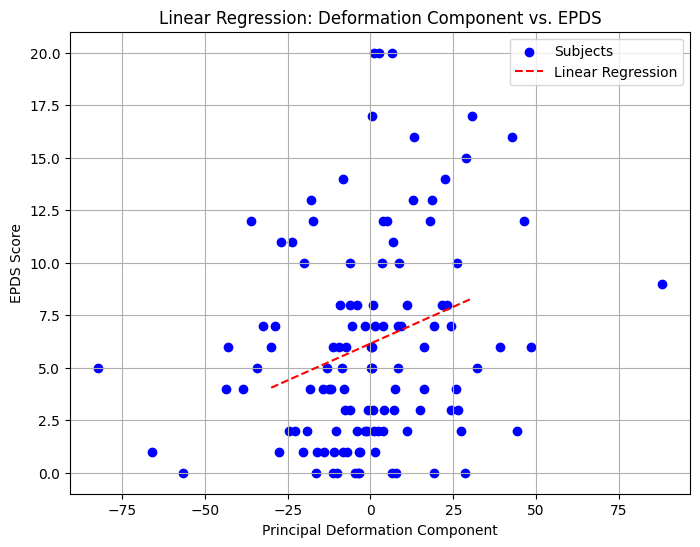

In [19]:
encoder = model.named_steps["prep"]
regressor = model.named_steps["regr"]

Z = encoder.transform(X)

z = np.linspace(-30.0, 30.0)[:, None]


plt.figure(figsize=(8, 6))
plt.scatter(Z, eds, color="blue", label="Subjects")
plt.plot(
    z,
    regressor.predict(z),
    color="red",
    linestyle="--",
    label="Linear Regression",
)
plt.legend()
plt.grid(True)
plt.xlabel("Principal Deformation Component")
plt.ylabel("EPDS Score")
plt.title("Linear Regression: Deformation Component vs. EPDS")